In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=scipy.integrate.IntegrationWarning)

Обернём код для построения графиков функций в функцию:

In [ ]:
def plot_function(f, min, max):
  xs = np.linspace(min, max, 100)
  ys = [f(x) for x in xs]
  plt.plot(xs, ys)

Создадим класс для работы с трапециевидными нечёткими множествами.

In [ ]:
def trapezoid_mf(a, b, c, d):
    return lambda x: \
      0 if x <= a or x >= d else \
      (x - a) / (b - a) if a < x <= b else \
      1 if b <= x <= c else \
      (d - x) / (d - c) if c < x <= d else \
      None

class FuzzySet:
  def __init__(self, a, b, c, d):
    self.mf = trapezoid_mf(a, b, c, d)
    self.min, self.max = a, d
    self.a, self.b, self.c, self.d = a, b, c, d

  def plot(self):
    xs = np.linspace(self.min, self.max, 100)
    ys = [self.mf(x) for x in xs]
    plt.plot(xs, ys)

  def specificity(self, u):
    ''' u - размер универсума '''
    return 1 - (self.c + self.d - (self.a + self.b)) / u

Для упрощения кода оформим в отдельную функцию построение гистограммы (как функции!) по набору данных.

In [ ]:
def histogram(data, bins):
  hist, bin_edges = np.histogram(data, bins, density=True)
  def h(x):
    for i in range(len(hist)):
      if bin_edges[i] <= x < bin_edges[i + 1]:
        return hist[i]
    return 0
  return h

Опишем проводимый эксперимент.

1) Для нескольких непрерывных вероятностных распределений (см. ниже список) сгенерируем выборки размера 1000.

In [ ]:
size = 1000
np.random.seed(42)

# выборки
datas = [
    np.random.normal(0, 1, size), # N(0,1)
    np.random.uniform(-2, 2, size), # Uniform(-2,2)
    np.random.exponential(1, size), # Exp(1)
]

# функции плотности распределений
distributions = [
    lambda x: scipy.stats.norm.pdf(x, 0, 1),
    lambda x: scipy.stats.uniform.pdf(x, -2, 4),
    lambda x: scipy.stats.expon.pdf(x)
]

2) Для каждого распределения зафиксируем некоторую A-часть Z-числа, которое должно описывать это распределение.

In [ ]:
fss = [
    FuzzySet(-2, -1, 0, 2),
    FuzzySet(-3, -1, 1, 3),
    FuzzySet(0, 0, 0, 5)
]

3) Оформим в отдельную функцию вычисление B-части Z-числа предложенным в работе способом.

In [ ]:
def calculateB(A: FuzzySet, data, distribution, bins_min=3, bins_max=size, bins_best=[np.ceil(np.log(size) / np.log(2)), np.ceil(np.sqrt(size))]):
  a, b = min(data.min(), A.a), max(data.max(), A.d)
  similarities = []
  best_sim = []
  for bins in tqdm(range(bins_min, bins_max + 1)):
    similarity = scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, bins)(x), a=a, b=b)[0]
    similarities.append(similarity)
    if bins in bins_best:
      best_sim.append((bins, similarity))
  plt.plot(similarities)
  # посчитаем "истинное" значение степени сходства с использованием известной функции плотности распределения
  true_sim = scipy.integrate.quad(lambda x: A.mf(x) * distribution(x), a=a, b=b)[0]
  plt.axhline(y=true_sim, color='r', linestyle='-', label='истинная степень уверенности')
  plt.title('График зависимости степени сходства от количества интервалов')
  plt.show()
  # отразим на графике вид A-части и гистограмму (для наглядности)
  plot_function(A.mf, a - 1, b + 1)
  plot_function(histogram(data, 'sturges'), a - 1, b + 1)
  plt.title('Гистограмма и график функции принадлежности A-части')
  plt.legend(['ФП A-части', 'гистограмма'])
  plt.show()
  print(f"Support of B = [{min(similarities)}, {max(similarities)}]")
  print(f"Possible peaks of B are:\n", best_sim)
  print(f"True similarity = {true_sim}")
  # выведем значения, получаемые при рассмотрении гистограмм с разбиением на 1 и на 2 интервала
  # при расчёте B-части мы не принимаем их во внимание, так как они имеют характер выбросов и отстоят слишком далеко от остальных значений
  print(f"Similarity for k=1: {scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, 1)(x), a=a, b=b)[0]}")
  print(f"Similarity for k=2: {scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, 2)(x), a=a, b=b)[0]}")

4) Запустим вычисления для всех распределений.

---------------------------------------


100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


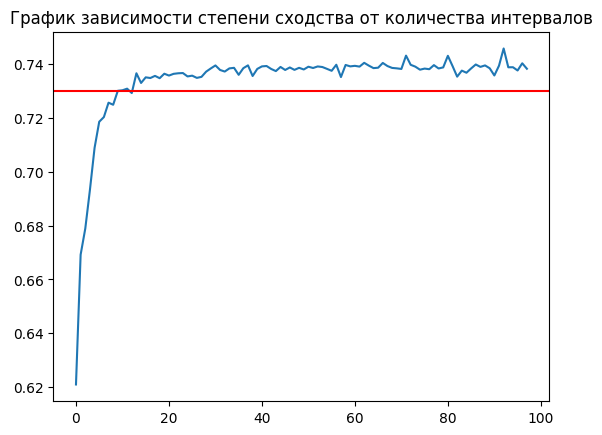

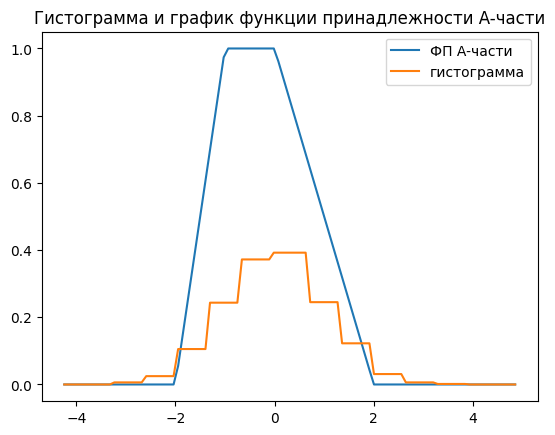

Support of B = [0.6208906361260499, 0.745896024292678]
Possible peaks of B are:
 [(10, 0.725725537250082), (32, 0.7384699781874835)]
True similarity = 0.7299494431184942
Similarity for k=1: 0.3524105454982647
Similarity for k=2: 0.3890321555552775
---------------------------------------

---------------------------------------


100%|██████████| 98/98 [00:34<00:00,  2.87it/s]


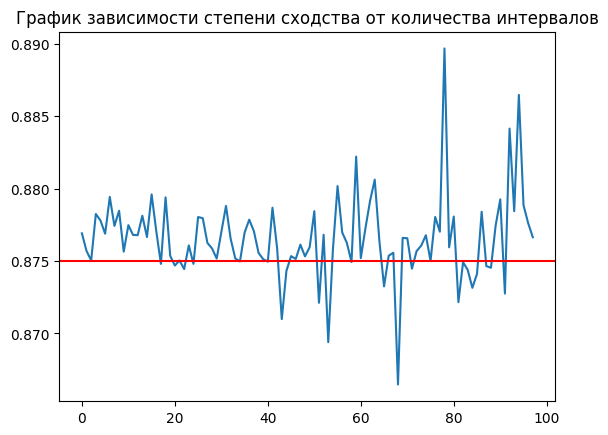

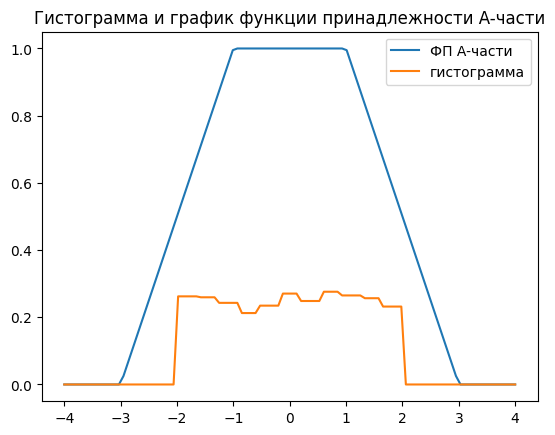

Support of B = [0.8664727477002622, 0.889680198471869]
Possible peaks of B are:
 [(10, 0.8774248780244805), (32, 0.8751704743866259)]
True similarity = 0.8750000000000004
Similarity for k=1: 0.8764230432251721
Similarity for k=2: 0.8763783343048412
---------------------------------------

---------------------------------------


100%|██████████| 98/98 [00:32<00:00,  3.02it/s]


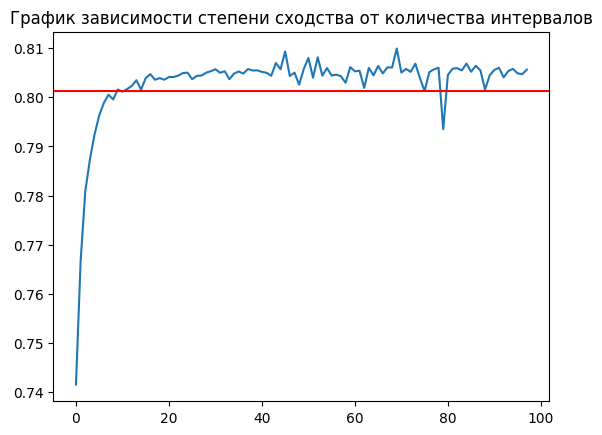

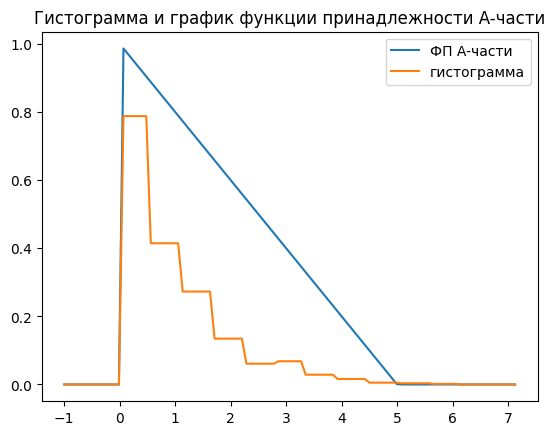

Support of B = [0.7415178452605538, 0.8099441522962014]
Possible peaks of B are:
 [(10, 0.8005396862370221), (32, 0.8053189550797097)]
True similarity = 0.8013475872573755
Similarity for k=1: 0.40790943847077005
Similarity for k=2: 0.6655663955932928
---------------------------------------



In [ ]:
for data, fs, distribution in zip(datas, fss, distributions):
  print("---------------------------------------")
  calculateB(fs, data, distribution, bins_max=100)
  print("---------------------------------------")
  print()